<a href="https://colab.research.google.com/github/asmaakhaledd/PID-NN/blob/Dataset-trial/PID-NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas tensorflow control matplotlib xmltodict scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 8.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/My Drive/OhioT1/"

Mounted at /content/drive


Convert XML to Pandas DataFrame

In [3]:
import xmltodict
import pandas as pd
import os

def parse_xml(file_path):
    with open(file_path, 'r') as file:
        data_dict = xmltodict.parse(file.read())
    return data_dict

# Extract relevant fields (Glucose, Insulin, Meals, etc.)
def extract_features(data_dict):
    patient_data = []
    patient = data_dict['patient']

    # Glucose events
    if 'glucose_level' in patient:
        for event in patient['glucose_level']['event']:
            entry = {
                'time': event['@ts'],
                'glucose': float(event['@value']),
                'insulin': 0,
                'meal': 0
            }
            patient_data.append(entry)

    # Insulin events
    if 'bolus' in patient:
        for event in patient['bolus']['event']:
            entry = {
                'time_begin': event['@ts_begin'],
                'time_end': event['@ts_end'],
                'glucose': 0,
                'insulin': float(event['@dose']),
                'meal': 0
            }
            patient_data.append(entry)

    # insulin event
    if 'basal' in patient:
        for event in patient['basal']['event']:
            entry = {
                'time': event['@ts'],
                'glucose': 0,
                'insulin': float(event['@value']),
                'meal': 0
            }

    # Meal events
    if 'meal' in patient:
        for event in patient['meal']['event']:
            entry = {
                'time': event['@ts'],
                'glucose': 0,
                'insulin': 0,
                'meal': float(event['@carbs'])
            }
            patient_data.append(entry)


    return pd.DataFrame(patient_data)

# Process all XML files in a folder
all_dataframes = []
for file in os.listdir(data_path):
    if file.endswith(".xml"):
        data_dict = parse_xml(os.path.join(data_path, file))
        df = extract_features(data_dict)
        all_dataframes.append(df)

# Combine all patients' data
df = pd.concat(all_dataframes, ignore_index=True)

# Convert time column to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')  # Automatically converts invalid times to NaT
df.dropna(subset=['time'], inplace=True)  # Drop rows where time is NaT
df.sort_values(by='time', inplace=True)

print(df.head())  # Preview dataset


                     time  glucose  insulin  meal time_begin time_end
61088 2021-08-30 11:53:00    116.0      0.0   0.0        NaN      NaN
61089 2021-08-30 11:58:00    117.0      0.0   0.0        NaN      NaN
73910 2021-08-30 11:59:00      0.0      0.0  37.0        NaN      NaN
61090 2021-08-30 12:03:00    119.0      0.0   0.0        NaN      NaN
61091 2021-08-30 12:08:00    116.0      0.0   0.0        NaN      NaN


<ipython-input-3-174a62d05f25>:74: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['time'] = pd.to_datetime(df['time'], errors='coerce')  # Automatically converts invalid times to NaT


Prepare Data for LSTM Model

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Use only glucose, insulin, and meal as input features
features = ['glucose', 'insulin', 'meal']
target = ['Kp', 'Ki', 'Kd']  # PID gains

# Normalize the features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Generate PID controller gains dynamically (example logic)
df['Kp'] = df['glucose'] * 0.01
df['Ki'] = df['glucose'] * 0.001
df['Kd'] = df['glucose'] * 0.0001

# Create sequences for LSTM (time-series format)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][features].values)
        y.append(data.iloc[i+seq_length][target].values)
    return np.array(X), np.array(y)

seq_length = 10  # Use past 10 timestamps for prediction
X, y = create_sequences(df, seq_length)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# converting to numeric
y_train = np.array(y_train, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)


In [5]:
print(X_train.dtype)
print(y_train.dtype)
print(X_test.dtype)
print(y_test.dtype)

float64
float64
float64
float64


Train the LSTM Neural Network

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM Model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(32, activation='tanh', return_sequences=False),
    Dense(16, activation='relu'),
    Dense(3, activation='linear')  # Outputs: Kp, Ki, Kd
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 5.4985e-06 - mae: 0.0013 - val_loss: 5.2654e-07 - val_mae: 3.8061e-04
Epoch 2/50
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 6.0240e-07 - mae: 4.6099e-04 - val_loss: 5.4401e-07 - val_mae: 4.2573e-04
Epoch 3/50
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 5.6343e-07 - mae: 4.2615e-04 - val_loss: 4.8138e-07 - val_mae: 3.6819e-04
Epoch 4/50
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 5.4910e-07 - mae: 3.9706e-04 - val_loss: 4.7497e-07 - val_mae: 3.5954e-04
Epoch 5/50
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 5.1304e-07 - mae: 3.6885e-04 - val_loss: 5.0845e-07 - val_mae: 3.5192e-04
Epoch 6/50
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 5.0677e-07 - mae: 3.4820e-04 - val_loss: 4.5798e-07 - val_mae: 3.2987e-04
Epoch 7/50
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 5.0490e-07 - mae: 3.4788e-04 - val_loss: 4.6444e-07 - val_mae: 3.4051e-04
Epoch 8/50
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 22s

Implement PID Controller

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


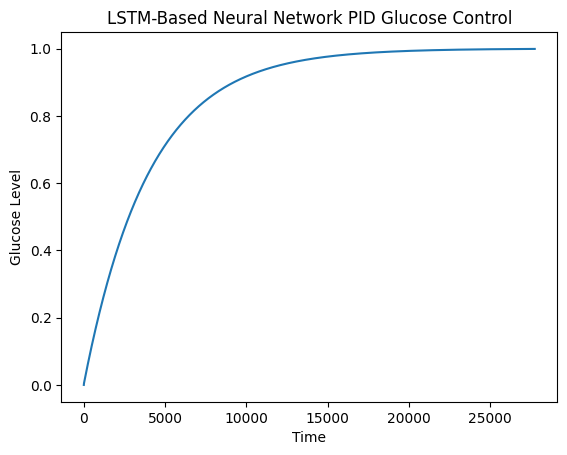

In [7]:
import control as ctrl

# Predict PID parameters using trained LSTM model
sample_input = X_test[0].reshape(1, seq_length, len(features))
Kp, Ki, Kd = model.predict(sample_input)[0]

# Define PID Controller
pid = ctrl.TransferFunction([Kd, Kp, Ki], [1, 0])  # PID equation

# Define a system response model
system = ctrl.tf([1], [1, 2, 1])  # Example glucose-insulin system

# Closed-loop system
closed_loop = ctrl.feedback(pid * system)

# Simulate step response
import matplotlib.pyplot as plt

time, response = ctrl.step_response(closed_loop)
plt.plot(time, response)
plt.xlabel('Time')
plt.ylabel('Glucose Level')
plt.title('LSTM-Based Neural Network PID Glucose Control')
plt.show()


Real-Time PID Tuning

In [10]:
import time
from collections import deque

# PID Control Variables
prev_error = 0
integral = 0
buffer = deque(maxlen=seq_length)  # Buffer for last 10 readings
dt = 5  # Time interval in seconds

def pid_control(glucose, set_point, Kp, Ki, Kd):
    global prev_error, integral

    # Calculate Error
    error = set_point - glucose

    # Proportional
    P = Kp * error

    # Integral
    integral += error * dt
    I = Ki * integral

    # Derivative
    derivative = (error - prev_error) / dt
    D = Kd * derivative

    # Total PID Output (Insulin Rate)
    insulin_rate = P + I + D

    # Save previous error
    prev_error = error

    return max(insulin_rate, 0)  # Ensure insulin rate is not negative

# Real-Time Glucose Simulation
set_point = 100  # Target glucose level (mg/dL)

while True:
    # Simulate real-time glucose level reading
    real_glucose = np.random.uniform(60, 180)  # Simulated glucose reading
    real_input = np.array([real_glucose, 0, 0])  # Glucose, Insulin, Meal

    # Normalize input
    real_input = scaler.transform([real_input])

    # Add to buffer
    buffer.append(real_input[0])

    if len(buffer) == seq_length:
        # Convert buffer to numpy array
        real_input = np.array(buffer).reshape(1, seq_length, len(features))

        # Get PID gains from the model
        Kp, Ki, Kd = model.predict(real_input)[0]

        # Calculate insulin rate
        insulin_rate = pid_control(real_glucose, set_point, Kp, Ki, Kd)

        print(f"Glucose: {real_glucose:.2f} mg/dL | Kp: {Kp:.4f} | Ki: {Ki:.4f} | Kd: {Kd:.4f} | Insulin Rate: {insulin_rate:.4f}")

    time.sleep(dt)  # Simulate real-time updates


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 78.67 mg/dL | Kp: 0.0038 | Ki: 0.0004 | Kd: 0.0000 | Insulin Rate: 0.1183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 99.18 mg/dL | Kp: 0.0033 | Ki: 0.0003 | Kd: -0.0000 | Insulin Rate: 0.0360
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 109.84 mg/dL | Kp: 0.0027 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 77.02 mg/dL | Kp: 0.0028 | Ki: 0.0003 | Kd: -0.0000 | Insulin Rate: 0.1114
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 69.23 mg/dL | Kp: 0.0030 | Ki: 0.0003 | Kd: -0.0000 | Insulin Rate: 0.1973
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 131.49 mg/dL | Kp: 0.0022 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 67.08 mg/dL | Kp: 0.0023 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.1555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 61.02 mg/dL | Kp: 0.0026 | Ki: 0.0003 | Kd: -0.0000 | Insulin Rate: 0.2397
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 139.01 mg/dL | Kp: 0.0023 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 168.09 mg/dL | Kp: 0.0027 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 97.69 mg/dL | Kp: 0.0030 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0089
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 86.94 mg/dL | Kp: 0.0034 | Ki: 0.0003 | Kd: 0.0000 | Insulin Rate: 0.0675
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 89.07 mg/dL | Kp: 0.0039 | Ki: 0.0004 | Kd: 0.0000 | Insulin Rate: 0.0896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 61.50 mg/dL | Kp: 0.0035 | Ki: 0.0004 | Kd: -0.0000 | Insulin Rate: 0.2459
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 138.34 mg/dL | Kp: 0.0023 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 130.25 mg/dL | Kp: 0.0027 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 158.08 mg/dL | Kp: 0.0030 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 84.54 mg/dL | Kp: 0.0034 | Ki: 0.0003 | Kd: 0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 111.06 mg/dL | Kp: 0.0039 | Ki: 0.0004 | Kd: 0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 123.65 mg/dL | Kp: 0.0033 | Ki: 0.0003 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 124.20 mg/dL | Kp: 0.0030 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 175.71 mg/dL | Kp: 0.0030 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 179.00 mg/dL | Kp: 0.0030 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 63.65 mg/dL | Kp: 0.0042 | Ki: 0.0004 | Kd: 0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 89.06 mg/dL | Kp: 0.0051 | Ki: 0.0005 | Kd: 0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 84.39 mg/dL | Kp: 0.0044 | Ki: 0.0004 | Kd: 0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 158.39 mg/dL | Kp: 0.0026 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 100.19 mg/dL | Kp: 0.0027 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 159.52 mg/dL | Kp: 0.0030 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 169.90 mg/dL | Kp: 0.0030 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 168.99 mg/dL | Kp: 0.0030 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 95.57 mg/dL | Kp: 0.0039 | Ki: 0.0004 | Kd: 0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 105.35 mg/dL | Kp: 0.0044 | Ki: 0.0004 | Kd: 0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 97.48 mg/dL | Kp: 0.0044 | Ki: 0.0004 | Kd: 0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 97.78 mg/dL | Kp: 0.0036 | Ki: 0.0003 | Kd: 0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 74.05 mg/dL | Kp: 0.0031 | Ki: 0.0003 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 75.22 mg/dL | Kp: 0.0030 | Ki: 0.0003 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 89.13 mg/dL | Kp: 0.0025 | Ki: 0.0003 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 79.94 mg/dL | Kp: 0.0021 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 137.87 mg/dL | Kp: 0.0022 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 80.69 mg/dL | Kp: 0.0026 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 177.18 mg/dL | Kp: 0.0028 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 74.03 mg/dL | Kp: 0.0030 | Ki: 0.0002 | Kd: -0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 71.66 mg/dL | Kp: 0.0037 | Ki: 0.0003 | Kd: 0.0000 | Insulin Rate: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Glucose: 64.55 mg/dL | Kp: 0.0035 | Ki: 0.0004 | Kd: -0.0000 | Insulin Rate: 0.0000


KeyboardInterrupt: 